In [300]:
import evaluation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt



In [301]:
data = load_breast_cancer()

X = data.data
y = data.target

print("Dataset shape:", X.shape)
print("Class distribution:")
print(pd.Series(y).value_counts())


Dataset shape: (569, 30)
Class distribution:
1    357
0    212
Name: count, dtype: int64


In [302]:
df = pd.DataFrame(X, columns=data.feature_names)

print(df.head())
print(df.describe())

print("Missing values:", df.isnull().sum().sum())

print(pd.Series(y).value_counts(normalize=True))


   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0           

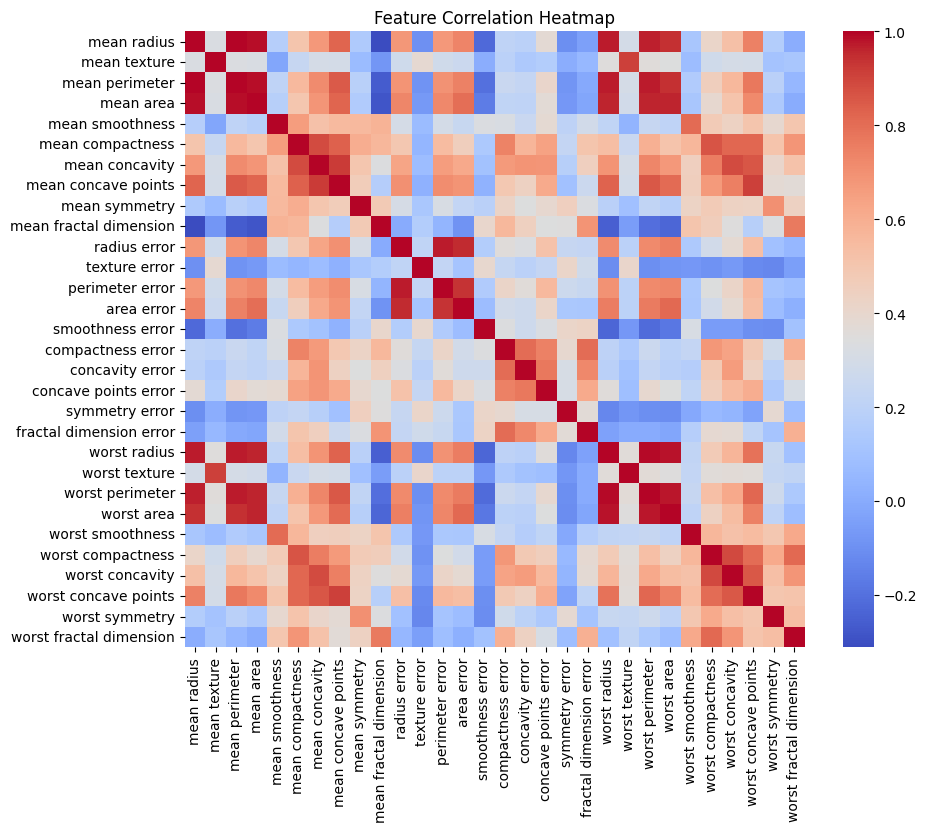

In [303]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [304]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (455, 30)
Test shape: (114, 30)


In [305]:
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_proba = model.predict_proba(X_train)[:, 1]

print("Model trained successfully.")

Model trained successfully.


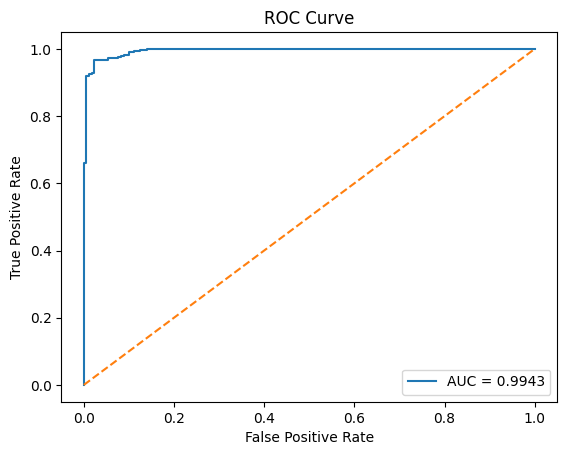

AUC (train): 0.9943446852425182


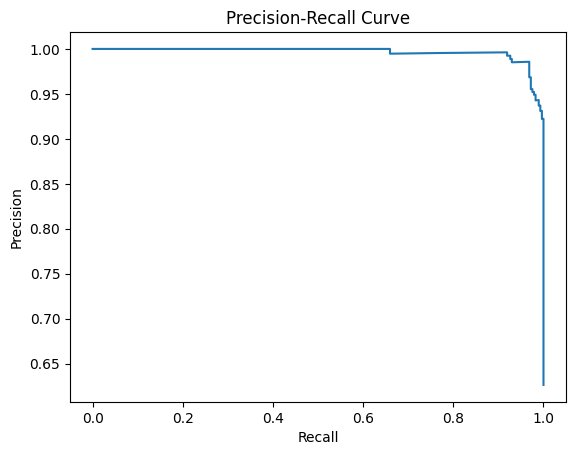

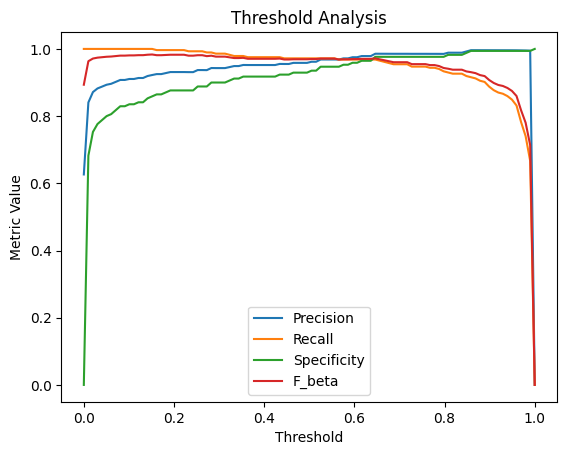

Best threshold (train):
threshold      0.151515
precision      0.922330
recall         1.000000
specificity    0.858824
f_beta         0.983437
Name: 15, dtype: float64


In [306]:
y_proba = model.predict_proba(X_train)[:, 1]

fpr, tpr, thresholds, roc_auc = evaluation.compute_roc_auc(y_train, y_proba)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)

print("AUC (train):", roc_auc)

precision_vals, recall_vals, pr_thresholds = evaluation.compute_pr_curve(y_train, y_proba)
evaluation.plot_pr_curve(precision_vals, recall_vals)

df_metrics = evaluation.threshold_sweep(y_train, y_proba, beta=2)
evaluation.plot_threshold_curves(df_metrics)

best = evaluation.find_best_threshold(df_metrics)

print("Best threshold (train):")
print(best)


In [307]:
y_proba = model.predict_proba(X_train)[:, 1]

y_pred = (y_proba >= 0.5).astype(int)

TP, FP, TN, FN = evaluation.confusion_matrix_binary(y_train, y_pred)

print("TP:", TP)
print("FP:", FP)
print("TN:", TN)
print("FN:", FN)

print("Precision:", evaluation.precision(TP, FP))
print("Recall:", evaluation.recall(TP, FN))
print("Specificity:", evaluation.specificity(TN, FP))
print("F1:", evaluation.fbeta_score(TP, FP, FN, beta=1))



TP: 277
FP: 12
TN: 158
FN: 8
Precision: 0.9584775086505191
Recall: 0.9719298245614035
Specificity: 0.9294117647058824
F1: 0.9651567944250871


In [308]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=5000)
log_model.fit(X_train, y_train)

y_train_proba_log = log_model.predict_proba(X_train)[:, 1]

print("Logistic Regression trained.")


Logistic Regression trained.


In [309]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_proba_rf = rf_model.predict_proba(X_train)[:, 1]

print("Random Forest trained.")


Random Forest trained.


In [310]:
# Train probabilities
y_train_proba_log = log_model.predict_proba(X_train)[:, 1]
y_train_proba_rf  = rf_model.predict_proba(X_train)[:, 1]



In [311]:
import evaluation
_, _, _, auc_log_train = evaluation.compute_roc_auc(y_train, y_train_proba_log)
_, _, _, auc_rf_train  = evaluation.compute_roc_auc(y_train, y_train_proba_rf)

print("Logistic Train AUC:", auc_log_train)
print("Random Forest Train AUC:", auc_rf_train)



Logistic Train AUC: 0.9943446852425182
Random Forest Train AUC: 0.9999999999999999


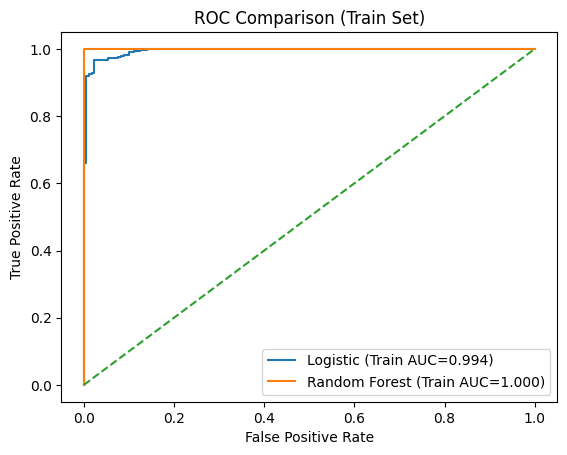

In [312]:
y_train_proba_log = log_model.predict_proba(X_train)[:, 1]
y_train_proba_rf  = rf_model.predict_proba(X_train)[:, 1]

fpr_log, tpr_log, _, auc_log = evaluation.compute_roc_auc(y_train, y_train_proba_log)
fpr_rf, tpr_rf, _, auc_rf = evaluation.compute_roc_auc(y_train, y_train_proba_rf)

plt.figure()
plt.plot(fpr_log, tpr_log, label=f"Logistic (Train AUC={auc_log:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (Train AUC={auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison (Train Set)")
plt.legend()
plt.show()


In [313]:
if auc_rf > auc_log:
    y_proba = y_proba_rf
    print("Final model: Random Forest")
else:
    y_proba = y_proba_log
    print("Final model: Logistic Regression")


Final model: Random Forest
